In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import modules
from src.features import stat_tests as st
from src.features import calculate_chart_params as cp
from src.features import functions as fn
from src.features import plot_functions as pf

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from scipy.stats import poisson

In [5]:
from sklearn.preprocessing import PowerTransformer

In [6]:
from statsmodels.graphics.gofplots import qqplot

#### poisson dist

In [7]:
mu0 = 2.5

In [8]:
poisson_series = pd.Series(fn.gen_rv(poisson, args=[mu0], size = 100))

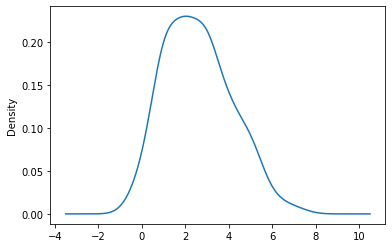

In [9]:
poisson_series.plot.kde()

#### Test for normality

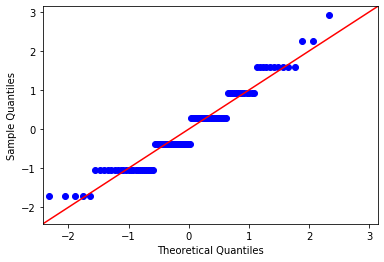

In [10]:
fig = qqplot(poisson_series, fit=True, line='45')
plt.show()

In [11]:
st.shapiro_wilks_(poisson_series)

Statistics=0.939, p=0.000
Sample does not look Gaussian (reject H0)


In [12]:
st.jarque_bera_(poisson_series)

Statistics=3.920, p=0.141, skew=0.455, kurt=2.666
Sample looks Gaussian (fail to reject H0)


#### Individual control chart (poisson)

In [13]:
in_control_mean = poisson_series.mean()

In [14]:
c_chart_params = cp.c_chart_params(poisson_series, center=mu0)

In [15]:
c_chart_params = c_chart_params.reset_index()

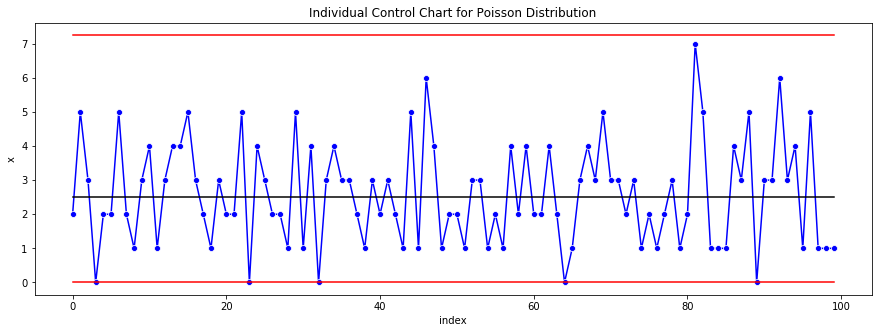

In [16]:
pf.plot_control_chart(
    data=c_chart_params,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart for Poisson Distribution',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)

#### Transform poisson dist 

In [17]:
pt = PowerTransformer(method='yeo-johnson', standardize=False, copy=True)

In [18]:
pt_fitted = pt.fit(poisson_series.values.reshape(-1, 1))

In [19]:
poisson_series_transformed = pd.Series(pt_fitted.transform(poisson_series.values.reshape(-1, 1)).flatten())

In [20]:
lambda_bc = pt_fitted.lambdas_

In [21]:
lambda_bc

array([0.47646651])

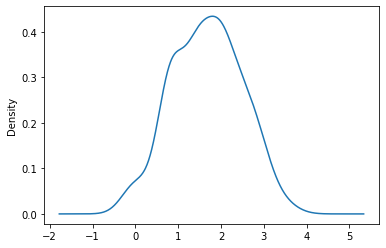

In [22]:
poisson_series_transformed.plot.kde()

#### Test for normality

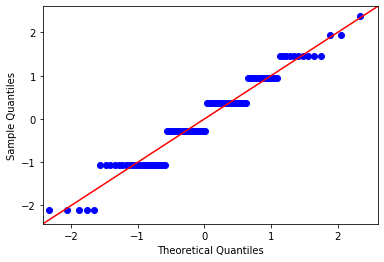

In [23]:
fig = qqplot(poisson_series_transformed, fit=True, line='45')
plt.show()

In [24]:
st.shapiro_wilks_(poisson_series_transformed)

Statistics=0.950, p=0.001
Sample does not look Gaussian (reject H0)


In [25]:
st.jarque_bera_(poisson_series_transformed)

Statistics=1.213, p=0.545, skew=-0.040, kurt=2.466
Sample looks Gaussian (fail to reject H0)


#### Individual control chart (transformed)

In [26]:
in_control_mean = poisson_series_transformed.mean()

In [27]:
MR  = cp.calculate_MR(poisson_series_transformed)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [28]:
in_control_mean, in_control_sigma

(1.6698867784835603, 0.8514604760903742)

In [29]:
x_ind_params = cp.x_ind_params(x = poisson_series_transformed, sigma = in_control_sigma, center=in_control_mean)

In [30]:
x_ind_params = x_ind_params.reset_index()

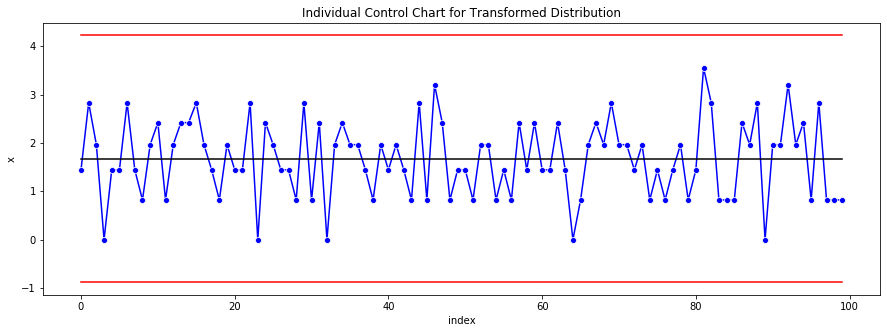

In [31]:
pf.plot_control_chart(
    data=x_ind_params,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart for Transformed Distribution',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)

#### Back transform to original

In [32]:
x_ind_params2 = x_ind_params.copy()

In [33]:
x_ind_params2['obs'] = pt_fitted.inverse_transform(x_ind_params2['obs'].values.reshape(-1, 1))
x_ind_params2['UCL'] = pt_fitted.inverse_transform(x_ind_params2['UCL'].values.reshape(-1, 1))
x_ind_params2['Center'] = pt_fitted.inverse_transform(x_ind_params2['Center'].values.reshape(-1, 1))
x_ind_params2['LCL'] = pt_fitted.inverse_transform(x_ind_params2['LCL'].values.reshape(-1, 1))

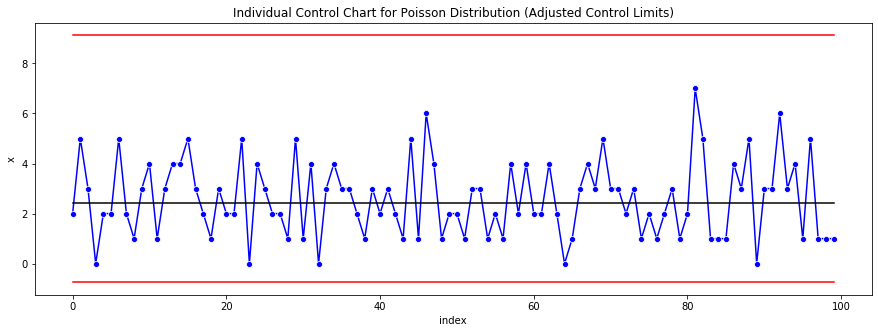

In [34]:
pf.plot_control_chart(
    data=x_ind_params2,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart for Poisson Distribution (Adjusted Control Limits)',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)

#### Check Probabilities

In [35]:
poisson.cdf(c_chart_params.UCL[0], mu0) - poisson.cdf(c_chart_params.LCL[0]-1e-10, mu0)

0.9957533045106555

In [36]:
poisson.cdf(x_ind_params2.UCL[0], mu0) - poisson.cdf(x_ind_params2.LCL[0]-1e-10, mu0)

0.9997226479053791